# In this notebook, we will explore the data to get a descriptive insight

In [17]:
import pandas as pd
import datetime as dt
import mysql.connector
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [18]:
conn = mysql.connector.connect(host='localhost',
                                         database='rossmann',
                                         user='root',
                                         password='root')
cursor = conn.cursor(buffered=True)

In [ ]:
sales=pd.read_csv(".\Cleaned Data\sales.csv")
stores=pd.read_csv(".\Cleaned Data\stores.csv")

# Brief description of the Data Dictionary

• Store: a unique ID for each store
• Sales: the turnover for a given day (our target y variable)
• Customers: the number of customers on a given day
• Open: an indicator for whether the store was open: 0 = closed, 1 = open
• StateHoliday: indicates a state holiday. 
    Normally all stores, with few exceptions, are closed on state holidays. 
    Note that all schools are closed on public holidays and weekends. 
    a = public holiday, b = Easter holiday, c = Christmas, 0 = none
• SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools
• StoreType: differentiates between four different store models: a, b, c, d
• Assortment: describes an assortment level: 
    a = basic, b = extra, c = extended
• CompetitionDistance: distance in meters to the nearest competitor store
• CompetitionOpenSince[Month/Year]: 
    gives the approximate year and month of the time the nearest competitor was opened
• Promo: indicates whether a store is running a promo on that day
• Promo2: Promo2 is a continuing and consecutive promotion for some stores: 
    0 = store is not participating, 1 = store is participating
• Promo2Since[Year/Week]: 
    describes the year and calendar week when the store started participating in Promo2
• PromoInterval: describes the consecutive intervals at which Promo2 is started, 
    naming the months the promotion is started anew (e.g., “Feb, May, Aug, Nov”
    means each round starts in February, May, August, and November of any given year for that store)

In [20]:
stores.PromoInterval.unique()

array([nan, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

In [21]:
sales=sales.merge(stores,on="Store")
sales.drop('Unnamed: 0_x', axis=1, inplace=True)
sales.head()

,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Source_x,Customers,Sales,...,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Source_y
0,1,4,2015-09-17,1,1,0,0,1,-1,-1,...,c,a,1270,9,2008,0,NaN,NaN,NaN,3
1,1,3,2015-09-16,1,1,0,0,1,-1,-1,...,c,a,1270,9,2008,0,NaN,NaN,NaN,3
2,1,2,2015-09-15,1,1,0,0,1,-1,-1,...,c,a,1270,9,2008,0,NaN,NaN,NaN,3
3,1,1,2015-09-14,1,1,0,0,1,-1,-1,...,c,a,1270,9,2008,0,NaN,NaN,NaN,3
4,1,7,2015-09-13,0,0,0,0,1,-1,-1,...,c,a,1270,9,2008,0,NaN,NaN,NaN,3


## First of all let us have an overall descriptive insight of the stores

### We see that most of the stores are of type a and very few of type b. Over the half of them are applying the promo2 and most of them are applying this promo2 in the months of January, April, July and october

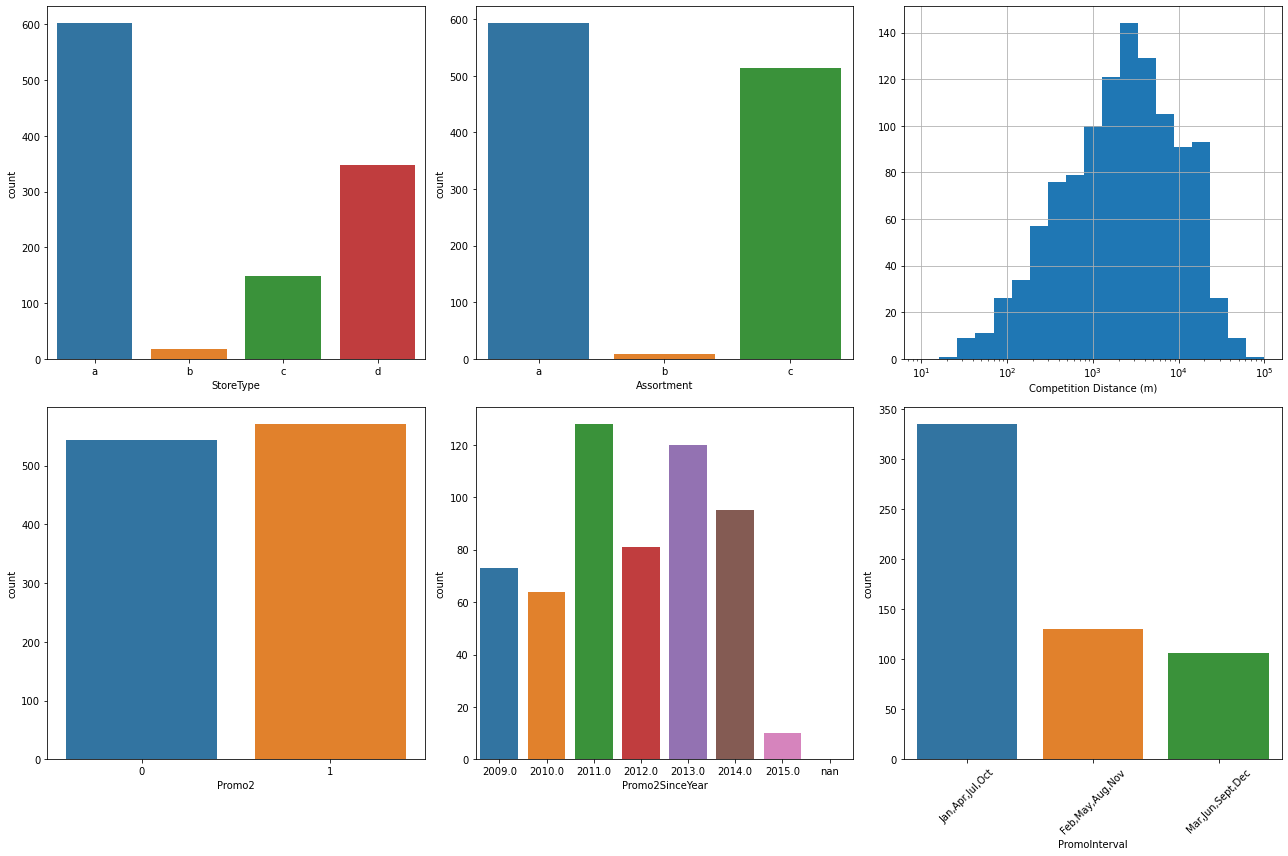

In [22]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

sns.countplot(x='StoreType', data=stores, order=np.sort(stores['StoreType'].unique()), ax=axes[0, 0])

sns.countplot(x='Assortment', data=stores, order=np.sort(stores['Assortment'].unique()), ax=axes[0, 1])

ax = stores['CompetitionDistance'].hist(bins=np.logspace(1, 5, 20), ax=axes[0, 2])
ax.set_xscale('log')
ax.set_xlabel('Competition Distance (m)')

sns.countplot(x='Promo2', data=stores, order=np.sort(stores['Promo2'].unique()), ax=axes[1, 0])

ax = sns.countplot(x='Promo2SinceYear', data=stores, 
                   order=np.sort(stores['Promo2SinceYear'].unique()), ax=axes[1, 1])



ax = sns.countplot(x='PromoInterval', data=stores, 
                   order=['Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'], ax=axes[1, 2])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


#axes[0,2].set_axis_off()
#axes[0,1].set_axis_off()
#axes[1,2].set_axis_off()
fig.tight_layout()

In [23]:
sales['Date']=pd.to_datetime(sales['Date'], infer_datetime_format=True)
avg_sales_storeType=sales[['Date', 'StoreType', 'Sales']].groupby(['Date', 'StoreType']).agg({'Sales':np.mean}).reset_index()
sum_sales_storeType=sales[['Date', 'StoreType', 'Sales']].groupby(['Date', 'StoreType']).agg({'Sales':np.sum}).reset_index()


### We see from the graphs below that although stores of type b are less represented, they sell in average per day more than other types of store.

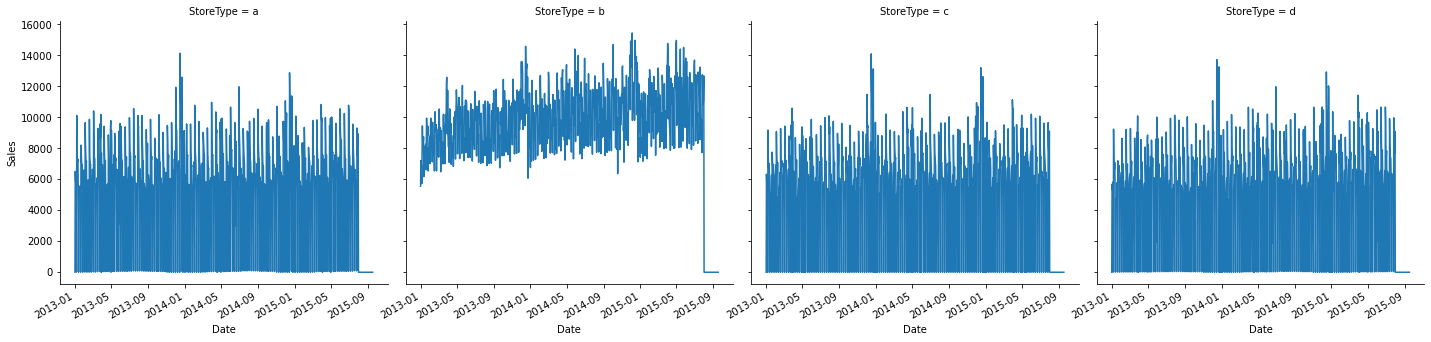

In [24]:
#sales_storeType=pd.DataFrame(sales_storeType)
#sales_storeType
#fig, ax = plt.subplots(figsize=(15, 5))
#fig=plt.figure(figsize=(8,15))
g=sns.relplot(x="Date", y="Sales", kind="line", col='StoreType', data=avg_sales_storeType )
#plt.title("Average sale by store type by day")
#plt.xlabel("something")
#plt.ylabel("Average sales") 

g.fig.autofmt_xdate()

### Let us see the top 20 store. we see from the table below that the top20 (stores selling the best per day in average) are mostly of type a and just three  of them are applying Promo2. Over the all period the apply a daily promotion 38% of the period of time  applyinng Promo2 does not seem to have that much influence on the sales

In [25]:
avg_sales_store=sales.groupby(['Store', 'StoreType'] ).agg({'Sales':np.mean, 
                                                                            'Promo':np.mean,
                                                                             'Promo2':np.mean,
                                                                            'CompetitionDistance':np.mean}).reset_index()

top20= avg_sales_store.sort_values(by='Sales', ascending=False).head(20)
top20

,Store,StoreType,Sales,Promo,Promo2,CompetitionDistance
261,262,b,19713.933333,0.382828,0,1180
816,817,a,18108.139066,0.382166,0,140
561,562,b,17098.256566,0.382828,0,1210
1113,1114,a,16366.198990,0.382828,0,870
512,513,a,15129.942675,0.382166,0,400
250,251,a,15047.294949,0.382828,0,340
787,788,a,14949.194268,0.382166,0,1530
841,842,d,14334.336228,0.378412,0,1200
732,733,b,14209.202020,0.382828,0,860
382,383,a,13626.091919,0.382828,0,350


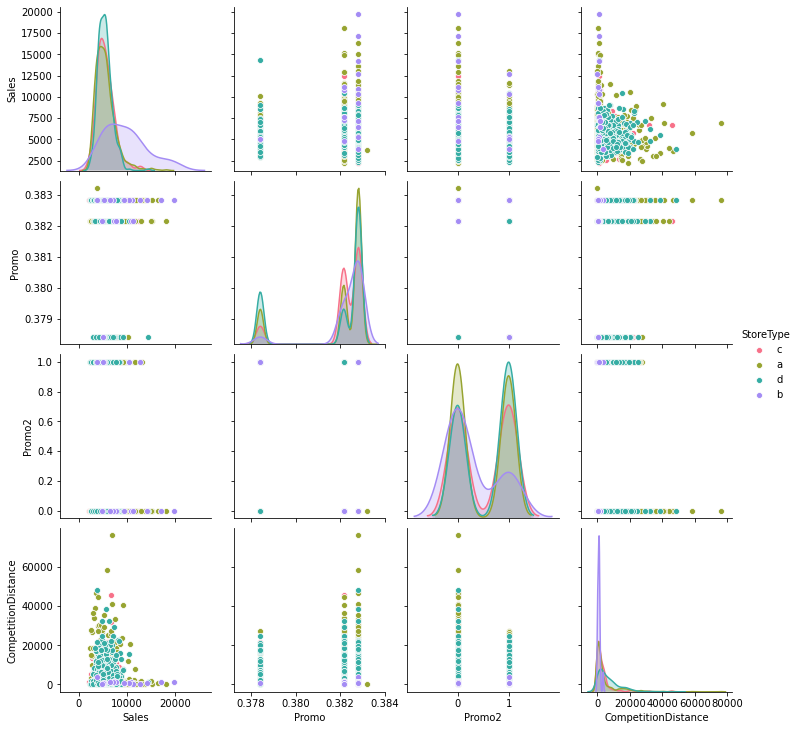

In [26]:
sns.pairplot(avg_sales_store[['StoreType', 'Sales', 'Promo', 'Promo2', "CompetitionDistance"]],hue="StoreType",
                             kind="scatter",palette="husl")

### Now let us add new variables to the dataset that gives for each day the month, the quarter, the year, the season it belongs to

In [27]:
sales["Month"] = sales["Date"].dt.month
sales["Quarter"] = sales["Date"].dt.quarter
sales["Year"] = sales["Date"].dt.year
sales["Day"] = sales["Date"].dt.day
sales["Week"] = sales["Date"].dt.week
sales["Season"] = np.where(sales["Month"].isin([3,4,5]),"Spring",
                            np.where(sales["Month"].isin([6,7,8]), "Summer",
                                     np.where(sales["Month"].isin ([9,10,11]),"Fall",
                                              np.where(sales["Month"].isin ([12,1,2]),"Winter","None"))))

In [28]:
sales_season=sales[['Season', 'Store','CompetitionDistance','StoreType','Promo2', 'Promo','Sales',
                    'PromoInterval']].groupby(['Store','StoreType','Promo','Promo2', 'Season']).agg({'Sales':np.mean, 'CompetitionDistance':np.mean}).reset_index()
sales_season

,Store,StoreType,Promo,Promo2,Season,Sales,CompetitionDistance
0,1,c,0,0,Fall,2950.074380,1270
1,1,c,0,0,Spring,3070.108434,1270
2,1,c,0,0,Summer,2681.276471,1270
3,1,c,0,0,Winter,3502.415584,1270
4,1,c,1,0,Fall,4439.423077,1270
...,...,...,...,...,...,...,...
8915,1115,d,0,1,Winter,4126.123377,5350
8916,1115,d,1,1,Fall,6136.358974,5350
8917,1115,d,1,1,Spring,6867.518182,5350
8918,1115,d,1,1,Summer,6468.783019,5350


### We see from the graphs below that Applying Promo2 does not seem to increase the sales whereas applying specific promo by day seems to increase the sales. Also competitiondistance does not seem to play a great role. One could expect the more a competitive store is closed the less will be the sales. But the logic seems not to be fulfilled

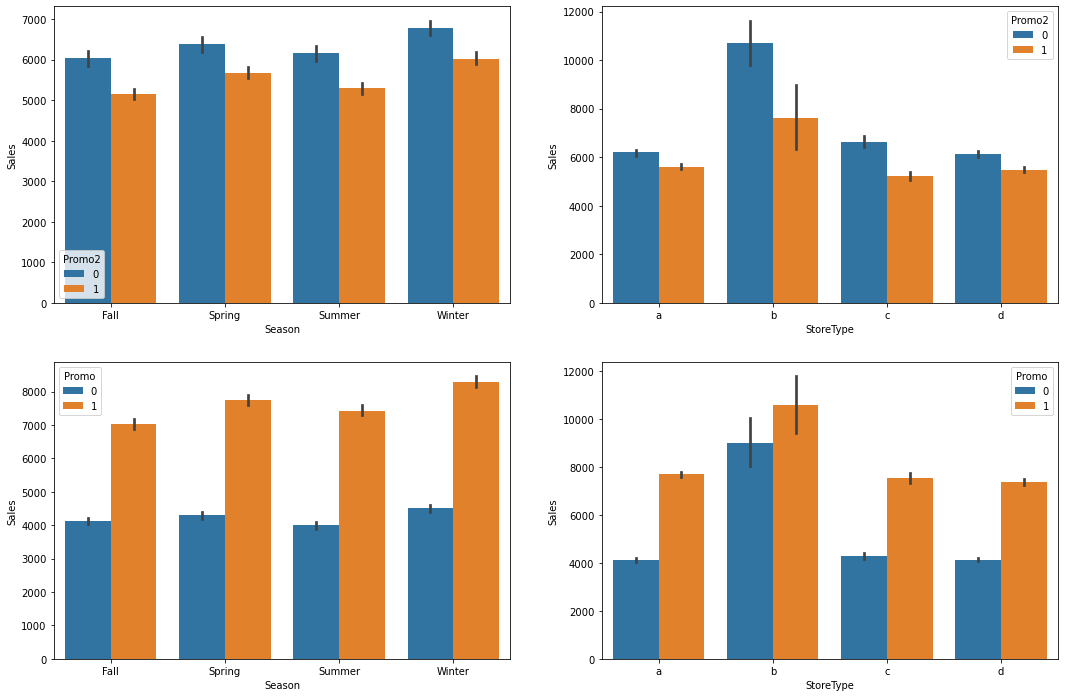

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
sns.barplot(x="Season", y="Sales", hue="Promo2", data=sales_season, order=np.sort(sales_season['Season'].unique()), ax=axes[0, 0]);
sns.barplot(x="StoreType", y="Sales", hue="Promo2", data=sales_season,order=np.sort(sales_season['StoreType'].unique()), ax=axes[0, 1]);
sns.barplot(x="Season", y="Sales", hue="Promo", data=sales_season, order=np.sort(sales_season['Season'].unique()), ax=axes[1, 0]);
sns.barplot(x="StoreType", y="Sales", hue="Promo", data=sales_season,order=np.sort(sales_season['StoreType'].unique()), ax=axes[1, 1]);

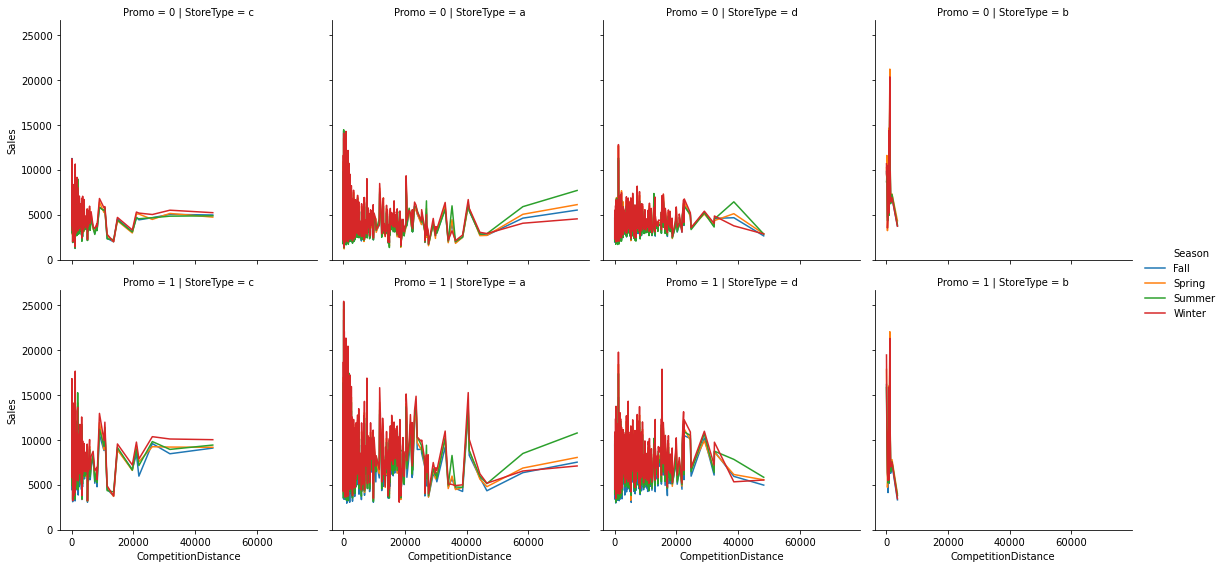

In [30]:
sns.relplot(x="CompetitionDistance", y="Sales", hue="Season",
            col="StoreType", row="Promo", height=4,
            kind="line", estimator=None, data=sales_season);